In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import torch
import time
import LocaNMF

In [2]:
import os
## [OPTIONAL] if cuda support, uncomment following lines
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"
# device='cuda'

# else, if on cpu
device='cpu'

# Load & Format Data

In [3]:
# Folder where the data is stored
# Get data from this link--> https://www.dropbox.com/s/q4m1v151o06zsdv/Vc_Uc.mat?dl=0
datafolder='./data/simulated/'

# File 'Vc_Uc.mat' in the above folder contains 'Uc', 'Vc', 'brainmask'. Simulated data also contains 'trueareas'.
arrays=sio.loadmat(datafolder+'Vc_Uc.mat')

In [4]:
# Get data in the correct format
new_x, new_y = 580, 540 # Brainmask limits x and y
V=arrays['Vc']
U=arrays['Uc'][:new_y, :new_x, :]
brainmask=~np.isnan(arrays['brainmask'][:new_y, :new_x])
brainmask_full=~np.isnan(arrays['brainmask'])
trueareas=arrays['trueareas'].flatten()
del arrays

# Get region based Allen map
dorsalMapScaled = sio.loadmat(datafolder+'dorsalMaps.mat')['dorsalMapScaled'].astype(float)
dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] = dorsalMapScaled[:,:int(dorsalMapScaled.shape[1]/2)] * -1
dorsalMapScaled = -dorsalMapScaled[:new_y, :new_x]

Rank of video : 58
Number of timepoints : 10000


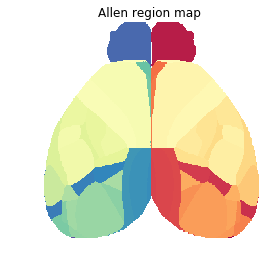

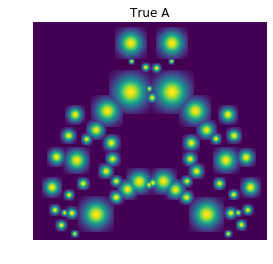

In [5]:
# Check that data has the correct shapes. V [K_d x T], U [X x Y x K_d], brainmask [X x Y]
if V.shape[0]!=U.shape[-1]: print('Wrong dimensions of U and V!')
print("Rank of video : %d" % V.shape[0]); print("Number of timepoints : %d" % V.shape[1]); 

# Plot the maximum U for each pixel
plotmap=np.zeros((dorsalMapScaled.shape)); plotmap.fill(np.nan); plotmap[brainmask]=dorsalMapScaled[brainmask]
plt.imshow(plotmap,cmap='Spectral'); plt.axis('off'); plt.title('Allen region map'); plt.show(); 
plt.imshow(np.max(U,axis=2)); plt.axis('off'); plt.title('True A'); plt.show()

In [6]:
# Perform the LQ decomposition. Time everything.
t0_global = time.time()
t0 = time.time()
q, r = np.linalg.qr(V.T)
time_ests={'qr_decomp':time.time() - t0}

# Initialize LocaNMF

In [7]:
# Put in data structure for LocaNMF
video_mats = (np.copy(U[brainmask]), r.T)
del U

In [8]:
minrank = 1; maxrank = 1; # rank = how many components per brain region. Set maxrank to around 10 for regular dataset.
rank_range = (minrank, maxrank, 1)
min_pixels = 100 # minimum number of pixels in Allen map for it to be considered a brain region

In [ ]:
# region_mats[0] = [unique regions x pixels] the mask of each region
# region_mats[1] = [unique regions x pixels] the distance penalty of each region
# region_mats[2] = [unique regions] area code
region_mats = LocaNMF.extract_region_metadata(brainmask,
                                            dorsalMapScaled,
                                            min_size=min_pixels)

In [ ]:
region_metadata = LocaNMF.RegionMetadata(region_mats[0].shape[0],
                                       region_mats[0].shape[1:],
                                       device=device)

region_metadata.set(torch.from_numpy(region_mats[0].astype(np.uint8)),
                    torch.from_numpy(region_mats[1]),
                    torch.from_numpy(region_mats[2].astype(np.int64)))

In [ ]:
# Do SVD
if device=='cuda': torch.cuda.synchronize()
print('v SVD Initialization')
t0 = time.time()
region_videos = LocaNMF.factor_region_videos(video_mats,
                                           region_mats[0],
                                           rank_range[1],
                                           device=device)
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['svd_init'] = time.time() - t0

v SVD Initialization
'-total : 0.204907


In [ ]:
low_rank_video = LocaNMF.LowRankVideo(
    (int(np.sum(brainmask)),) + video_mats[1].shape, device=device
)
low_rank_video.set(torch.from_numpy(video_mats[0].T),
                   torch.from_numpy(video_mats[1]))

# LocaNMF

In [ ]:
loc_thresh=70
r2_thresh=0.99
if device=='cuda': torch.cuda.synchronize()
print('v Rank Line Search')
t0 = time.time()
locanmf_comps = LocaNMF.rank_linesearch(low_rank_video,
                                      region_metadata,
                                      region_videos,
                                      maxiter_rank=maxrank-minrank+1,
                                      maxiter_lambda=20, 
                                      maxiter_hals=20,
                                      lambda_step=1.35,
                                      lambda_init=1e-6, 
                                      loc_thresh=loc_thresh,
                                      r2_thresh=r2_thresh,
                                      rank_range=rank_range,
                                      verbose=[True, False, False],
                                      sample_prop=(1,1),
                                      device=device
                                     )
if device=='cuda': torch.cuda.synchronize()
print("\'-total : %f" % (time.time() - t0))
time_ests['rank_linesearch'] = time.time() - t0

v Rank Line Search
|--v Rank Line Search Iteration 0
|  |--v Initialization
|  |  '-total : 0.059474 seconds
|  |--v Lambda Line Search


In [ ]:
print("Number of components : %d" % len(locanmf_comps))

In [ ]:
# Evaluate R^2
_,r2_fit=LocaNMF.evaluate_fit_to_region(low_rank_video,
                                       locanmf_comps,
                                       region_metadata.support.data.sum(0),
                                       sample_prop=(1, 1))
print("R^2 fit on all data : %f" % r2_fit)

time_ests['global_time'] = time.time()-t0_global

# Reformat spatial and temporal matrices, plot, and save

In [ ]:
# Assigning regions to components
region_ranks = []; region_idx = []
for rdx in torch.unique(locanmf_comps.regions.data, sorted=True):
    region_ranks.append(torch.sum(rdx == locanmf_comps.regions.data).item())
    region_idx.append(rdx.item())
areas=np.repeat(region_mats[2],region_ranks,axis=0)

In [ ]:
# Get LocaNMF spatial and temporal components
A=locanmf_comps.spatial.data.cpu().numpy().T
A_reshape=np.zeros((brainmask_full.shape[0],brainmask_full.shape[1],A.shape[1])); A_reshape.fill(np.nan)
A_reshape[brainmask_full,:]=A

C=np.matmul(q,locanmf_comps.temporal.data.cpu().numpy().T).T

In [ ]:
# Plotting all the regions' components
A_validmask=np.zeros((brainmask_full.shape[0],brainmask_full.shape[1])); A_validmask.fill(np.nan)
for rdx, i in zip(region_idx, np.cumsum(region_ranks)-1):
    fig, axs = plt.subplots(1 + int((1+region_ranks[rdx]) / 4), 4,
                            figsize=(16,(1 + int((1+region_ranks[rdx]) / 4)) * 4))
    axs = axs.reshape((int(np.prod(axs.shape)),))
    A_validmask[brainmask_full] = locanmf_comps.distance.data[i].cpu()==0
    axs[0].imshow(A_validmask)
    axs[0].set_title("Region: {}".format(rdx+1)); axs[0].axis('off')
    
    # only for simulated data
    A_validmask[brainmask_full]=video_mats[0][:,np.where(areas[i]==trueareas)[0][0]]
    axs[1].imshow(A_validmask)
    axs[1].set_title("True A: {}".format(rdx+1)); axs[1].axis('off')
    
    axs[2].imshow(A_reshape[:,:,i])
    axs[2].set_title("LocaNMF A: {}".format(i+1)); axs[2].axis('off')
    
    axs[3].plot(V[np.where(areas[i]==trueareas)[0][0],:3000].T,'k'); axs[3].plot(C[i,:3000].T,'r');
    axs[3].set_title("True & LocaNMF C: {}".format(i+1));axs[3].axis('off'); 
    if i==0: axs[3].legend(('True','LocaNMF'))
    
    plt.show()

In [ ]:
# Plot the distribution of lambdas. 
# If lots of values close to the minimum, decrease lambda_init.
# If lots of values close to the maximum, increase maxiter_lambda or lambda_step.
plt.hist(np.log(locanmf_comps.lambdas.data.cpu()), bins=torch.unique(locanmf_comps.lambdas.data).shape[0])
plt.show()

In [ ]:
sio.savemat(datafolder+'locanmf_decomp_loc'+str(loc_thresh)+'.mat',
            {'C':C,
             'A':A_reshape,
             'lambdas':locanmf_comps.lambdas.data.cpu().numpy(),
             'areas':areas,
             'r2_fit':r2_fit,
             'time_ests':time_ests
            })

In [ ]:
torch.cuda.empty_cache()